In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/archive/mnist_train.csv")
Y = df['label']
X = df.drop('label',axis= 1)

In [6]:
X.sample(10).iloc[:,200:]

,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
58669,0,0,0,0,0,0,0,0,0,152,...,0,0,0,0,0,0,0,0,0,0
55964,0,0,0,0,0,0,0,46,226,247,...,0,0,0,0,0,0,0,0,0,0
53861,0,0,0,0,0,57,229,253,253,234,...,0,0,0,0,0,0,0,0,0,0
51196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36081,0,0,0,0,0,0,16,250,133,8,...,0,0,0,0,0,0,0,0,0,0
12280,0,0,0,0,0,0,1,28,131,192,...,0,0,0,0,0,0,0,0,0,0
31387,0,0,0,0,0,0,0,0,57,86,...,0,0,0,0,0,0,0,0,0,0
31163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15894,0,0,0,0,0,57,254,94,0,198,...,0,0,0,0,0,0,0,0,0,0
48094,0,0,0,0,67,240,251,251,251,229,...,0,0,0,0,0,0,0,0,0,0


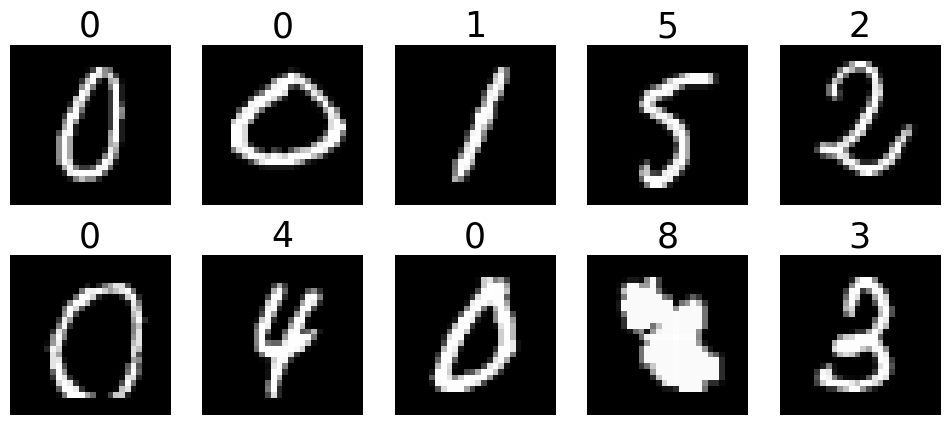

In [7]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    axes[i].imshow(X.iloc[idx[i],:].values.reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(Y[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [8]:
# Test-Train-Val Dataset Spliting.

x_t,x_test,y_t,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)
x_train,x_val,y_train,y_val = train_test_split(x_t,y_t,test_size=0.2,random_state=42)

In [9]:
# Normalizing the Dataset.

normalizer = Normalizer()
x_train = normalizer.fit_transform(x_train)
x_val = normalizer.transform(x_val)
x_test = normalizer.transform(x_test)

In [10]:
lst = list(range(1,11))

## Dataset & Dataloader class

1. Basic Idea behind the Dataset and DataLoader class is to be decoupled from our model training code for better readability and modularity.
2. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.
3. Dataset class stores the samples and their corresponding labels, and DataLoader class wraps an iterable around the Dataset to enable easy access to the samples.

## Dataset Class

A custom Dataset class must implement three functions: ``__init__``, ``__len__``, and ``__getitem__``.

1. The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms
2. The __len__ function returns the number of samples in our dataset.
3. The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the sample and label and return it as a tuple.

In [11]:
class CustomDataset(Dataset):

  def __init__(self,features,label):
    self.features = features
    self.label = label

  def __len__(self):
    return self.features.shape[0]

  def __getitem__(self,idx):

    sample = self.features[idx]
    label = self.label.values[idx]
    sample_tensor = torch.tensor(sample,dtype = torch.float32)
    label_tensor = torch.tensor(label,dtype = torch.long)

    return sample_tensor,label_tensor

In [12]:
train_dataset = CustomDataset(x_train,y_train)
val_dataset = CustomDataset(x_val,y_val)
test_dataset = CustomDataset(x_test,y_test)

## DataLoader Class

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing(num_worker) to speed up data retrieval.

`DataLoader is an iterable that abstracts this complexity for us in an easy API.`

When we load the dataset into the DataLoader and we can iterate through the dataset as needed.


In [13]:
batch_size = 64
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
print(device)

cpu


In [15]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size = batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled.

In [16]:
data,label = next(iter(train_dataloader))
print(data[:,278:300])
print(label)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0387, 0.0855, 0.0855],
        [0.0000, 0.0000, 0.0000,  ..., 0.0304, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0339],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0693, 0.1168],
        [0.0000, 0.0000, 0.0000,  ..., 0.1266, 0.0693, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1086, 0.0825, 0.0000]])
tensor([0, 3, 3, 6, 9, 7, 7, 4, 0, 8, 6, 1, 2, 1, 7, 2, 0, 4, 1, 3, 1, 8, 4, 6,
        4, 5, 5, 8, 4, 6, 9, 4, 5, 4, 3, 9, 3, 4, 1, 1, 1, 3, 7, 9, 0, 5, 4, 8,
        3, 5, 9, 0, 8, 3, 1, 4, 3, 6, 2, 3, 5, 2, 7, 3])



## `torch.nn.Module` and `torch.nn.Parameter`


Except for `Parameter`, the classes we will be discussing are all subclasses of `torch.nn.Module`.

`torch.nn.module` is the PyTorch base class which is meant to encapsulate behaviors specific to `PyTorch Models` and their `Components` like activation functions etc.

One of the important behavior of `torch.nn.Module` is registering(Intializing) parameters for the layers defined using subclass of `Module`

For Example:
`Module` subclass ,`nn.Linear()` has learning weights, these weights are expressed as instances of `torch.nn.Parameter` class.

The `Parameter` class is a subclass of `torch.Tensor`, with the special behavior that when they are assigned as attributes of a `Module`, they are added to the list of that modules parameters. These parameters can be accessed through the `parameters()` method on the `Module` class.

As a simple example, we will be going to build a simple FFNN for MNIST Dataset for Digit Recognition

## Simple Model

In [17]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


## Using Functional Interface
```
1. It's a functional interface where we directly pass the input tensor to it and get the activated output.
2. It does not hold or manage any internal state and therefore stateless.
3. Since it's stateless, it's ideal when you don't need the module to track activations as part of the model's stateful components.

```

In [18]:
class FunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Using nn.Sequential

```
1. This approach represent Model as a sequence of Operations.
2. It the most concise way to define a model, but it offers less flexibility for models that require complex data flows or custom operations.
3. "nn.Sequential" expects modules as its arguments.
```

In [19]:
class SeqModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
                            nn.Linear(784, 512),
                            nn.ReLU(),
                            nn.Linear(512, 512),
                            nn.ReLU(),
                            nn.Linear(512, 10))

  def forward(self,x):
    return self.layer(x)


## Using Batch Normalization and Dropout Layers

In [20]:
class Model(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,512)
    self.batch_norm1 = nn.BatchNorm1d(512)
    self.relu1 = nn.ReLU()
    self.dropout_1 = nn.Dropout(p = 0.2)
    self.fc2 = nn.Linear(512,512)
    self.batch_norm2 = nn.BatchNorm1d(512)
    self.relu2 = nn.ReLU()
    self.dropout_2 = nn.Dropout(p = 0.2)
    self.fc3 = nn.Linear(512,10)

  def forward(self,x):
    x = self.dropout_1(self.relu1(self.batch_norm1(self.fc1(x))))
    x = self.dropout_2(self.relu2(self.batch_norm2(self.fc2(x))))
    x = self.fc3(x)
    return x

In [21]:
model = Model().to(device)

In [22]:
a = torch.tensor(5)

In [23]:
a.item()

5

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 100
patience = 5
best_loss = float('inf')
count = 0

In [27]:
for epoch in range(epochs):

    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for data, label in train_dataloader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, label in val_dataloader:
            data, label = data.to(device), label.to(device)
            outputs = model(data)
            loss = criterion(outputs, label)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += label.size(0)
            val_correct += (predicted == label).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_dataloader)

    # Early stopping
    if val_loss < best_loss:
        count = 0
        best_loss = val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }
        torch.save(checkpoint, f"Model_checkpoint_{epoch+1}.pth")
    else:
        count += 1
        if count == patience:
            print("Early Stopping !!!")
            break

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/100], Train Loss: 0.2281, Train Accuracy: 92.96%, Val Loss: 0.1050, Val Accuracy: 96.85%
Epoch [11/100], Train Loss: 0.0277, Train Accuracy: 99.05%, Val Loss: 0.0705, Val Accuracy: 98.17%
Early Stopping !!!


## Model Testing

In [29]:
# Load the saved model checkpoint
checkpoint_path = '/content/Model_checkpoint_9.pth'
checkpoint = torch.load(checkpoint_path)

# Assuming model is defined elsewhere in your code
model.load_state_dict(checkpoint['model_state_dict'])

# Put model in evaluation mode
model.eval()

# Load your test dataset
# Assuming test_dataloader is defined elsewhere in your code and loaded with test data
test_dataloader = test_dataloader

# Define the loss function for testing
loss_func = nn.CrossEntropyLoss()

# Initialize variables to monitor test performance
test_loss = 0
correct = 0

# No gradient updates needed for testing
with torch.no_grad():
    for data, label in test_dataloader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = loss_func(pred, label)
        test_loss += loss.item()
        correct += (pred.argmax(1) == label).sum().item()

# Calculate average loss and accuracy over the test set
test_loss /= len(test_dataloader.dataset)
test_accuracy = 100. * correct / len(test_dataloader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0011, Test Accuracy: 98.17%


In [ ]:
# init.xavier_uniform_(layer1.weight)
# def reinitialize_model(model):
#     for layer in model.modules():
#         if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#             # Reinitialize weights using an init function
#             init.sparse_(layer.weight,sparsity = 0.1,std=0.01)

#             # Reinitialize biases to zero (if biases exist)
#             if layer.bias is not None:
#                 init.zeros_(layer.bias)

# # Apply the function to your model

# reinitialize_model(model)